need to do - review colours for red, green and yellow
improve x-y coordinate stuff
work on get force stuff!

In [14]:
# Import all libraries!
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil
import time
from urx.robotiq_two_finger_gripper import Robotiq_Two_Finger_Gripper
import logging
import urx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


logging.basicConfig(level=logging.CRITICAL)
# HOW TO REMOVE LOGGING MESSAGES!!!?


In [58]:
# rob = rob_connect()
# robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
cam_init_pos = [-0.00043183961977177887, -1.651595417653219, -1.226389233266012, -1.276344124470846, -4.72298783460726, 0.001785649568773806]
bucket_pos = [1.6486937999725342, -2.4073990027057093, -1.8858941237079065, -0.36886865297426397, -4.742553655301229, 0.0471811443567276]
# rob.movec(cam_init_pos, bucket_pos, acc = 0.5, vel = 2)
# rob.movejs([cam_init_pos, bucket_pos], acc = 0.5, vel = 2, radius=0.2)

moved to init position
Please enter the number of bins you have: 2
Press color of bin when complete: red
Press color of bin when complete: green
Completed all bins!
moved to init position


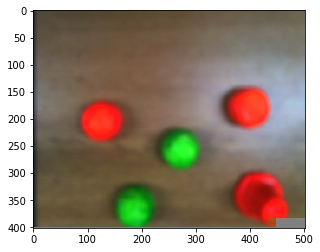

image recieved
pixel count: 17386
centerpoints at: x: 421 y: 346
centerpoints at: x: 127 y: 203
centerpoints at: x: 396 y: 179
top left points are: x: 127 y: 203


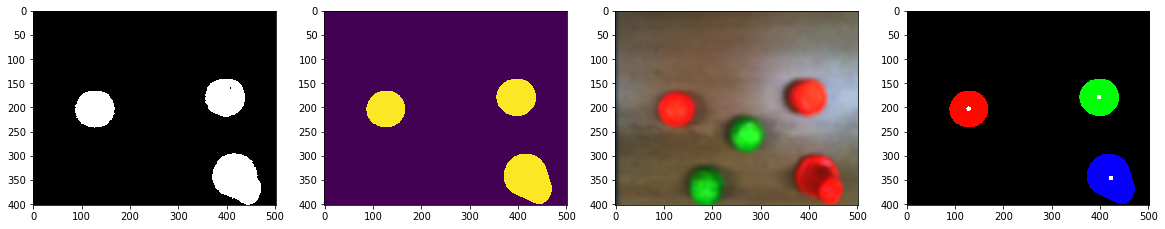

-0.0989928429282
0.0100043463239
moved to init position


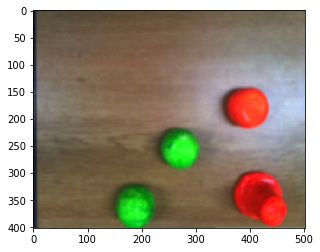

image recieved
pixel count: 11801
centerpoints at: x: 420 y: 345
centerpoints at: x: 395 y: 179
centerpoints at: x: 413 y: 170
top left points are: x: 395 y: 179


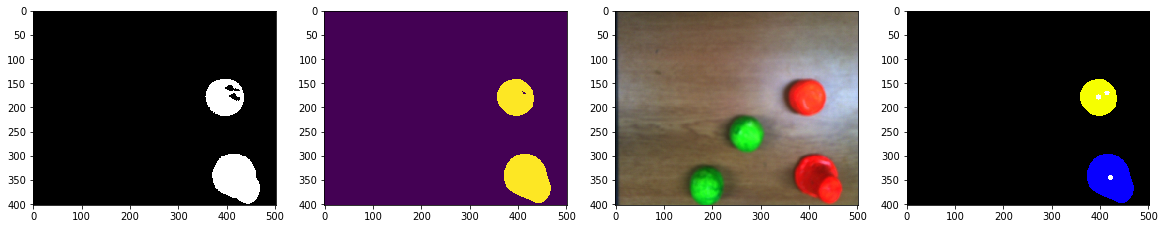

0.13908435851
-0.00958404505252
moved to init position


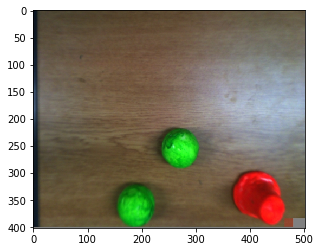

image recieved
pixel count: 6886
centerpoints at: x: 417 y: 344
top left points are: x: 417 y: 344


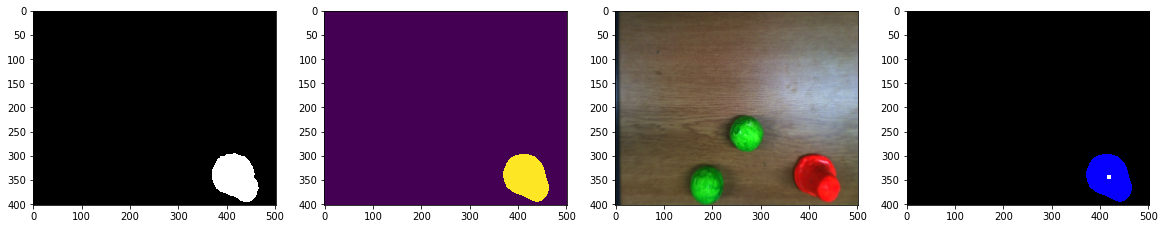

0.157605735608
0.127738271876
moved to init position


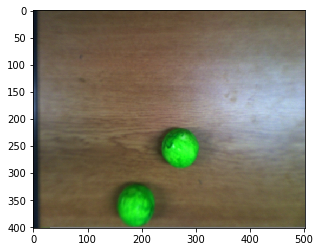

image recieved
pixel count: 0
no more objects in scene of colour: red
moved to init position


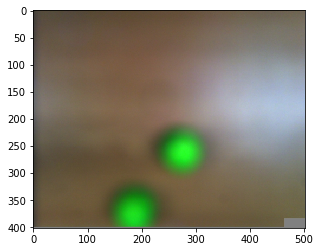

image recieved
pixel count: 10937
centerpoints at: x: 187 y: 366
centerpoints at: x: 273 y: 259
top left points are: x: 273 y: 259


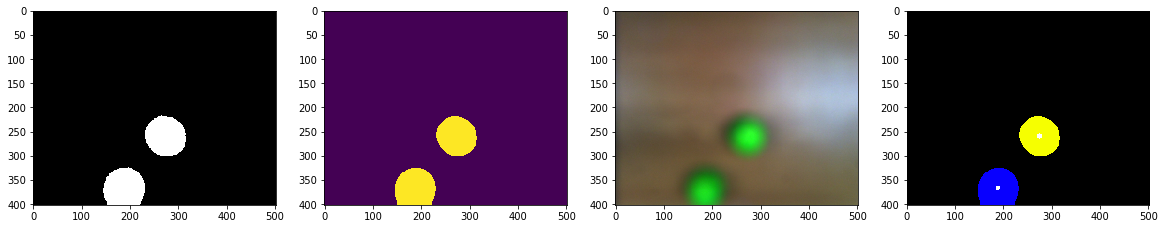

0.0318085613599
0.056159466951
moved to init position


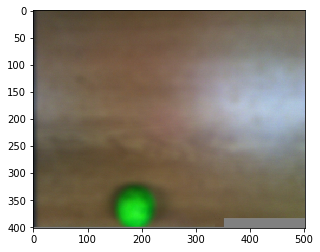

image recieved
pixel count: 4960
centerpoints at: x: 188 y: 363
top left points are: x: 188 y: 363


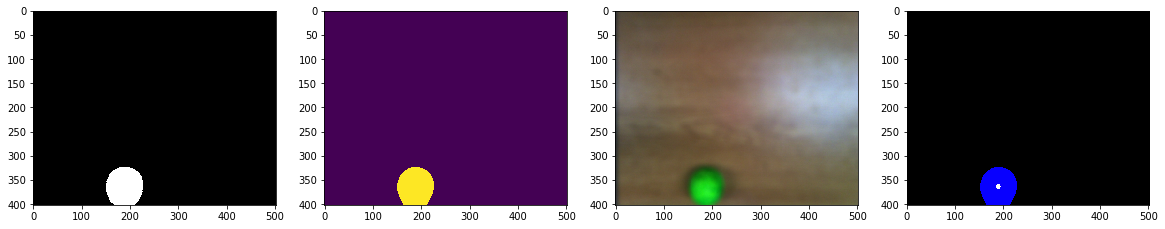

-0.0462068287594
0.1439269555
moved to init position


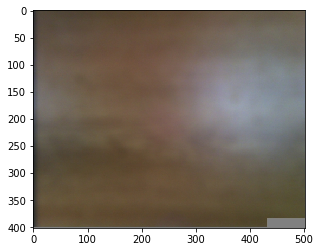

image recieved
pixel count: 0
no more objects in scene of colour: green
finishing program


In [60]:
%matplotlib inline

# initalise
rob = rob_connect()
robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
a = 0.7; v = 2


robotiqgrip.open_gripper()
go_to_start(rob)
[colours, bins] = teach_bins(rob)
i = 0

while True:
    if i == len(colours):
        print("finishing program")
        break
        
    go_to_start(rob)
    time.sleep(1)
    get_image()
    distance = detect_photos(colours[i])
    
    if distance == None:
        i+=1
        continue
        

    [x_dist, y_dist] = find_distance(im_x = distance[0], im_y = distance[1])
    print(x_dist)
    print(y_dist)

#     rob.translate((y_dist, x_dist, 0), acc=a, vel=v)
#     rob.translate((-0.095, 0, 0), acc=a, vel=v)
#     rob.translate((0, 0, -0.33), acc=a, vel=v)
    rob.translate((y_dist-0.095, x_dist, -0.33), acc=a, vel=v)

    robotiqgrip.close_gripper()
#     go_to_start(rob)
#     rob.movej(bins[i], acc = a, vel = v)
    rob.movejs([cam_init_pos, bins[i]], acc = a, vel = v, radius=0.2)
    robotiqgrip.open_gripper()




#################3

# pose = rob.getj()
# print(pose)
# # pose[3] = pose[3] - 0.57
# # rob.movel(pose, acc = a, vel = v)

# rob.movel_tool([0, 0, 0, -0.43, 0, 0],acc=a, vel=v)

rob.close()

In [44]:
## get robot back into init pos
test_robot(a = 1, v = 1)


('robot tcp is at pose: ', [8.388957940042019e-05, -1.9092310110675257, -0.908236328755514, -1.3371108214007776, -4.723095719014303, 0.0019773971289396286])


In [2]:
def move_over_object(rob, x_diff, y_diff):
    '''
    Function to move over identified object
    '''
#     factor = 3025.0
#     factor = 1500
    
    x_diff = float(x_diff)/700
    y_diff = float(y_diff)/1300
    
    
    print(x_diff, y_diff)
    
    rob.translate((y_diff, x_diff, 0), acc=a, vel=v)
    

In [3]:
def teach_bins(rob):
    '''
    Allows user to move robot to placement of bins
    Also need to allow user to take photo of object!??
    '''
    colours = []
    bins = []
    n_bins = int(raw_input("Please enter the number of bins you have: "))
    for i in range(n_bins):
        rob.set_freedrive(1, timeout=60)
        colours.append(raw_input("Press color of bin when complete: "))
        bins.append(rob.getj())
        
    print("Completed all bins!")
    return [colours, bins]

In [4]:
def rotate_to_shape(rob):
    '''
    rotate robot gripper to face objects below
    '''
#     pose = rob.getj()
#     pose[3] = pose[3] - 0.57
#     rob.movej(pose, acc = a, vel = v)
    rob.movel_tool([0, 0, 0, -0.43, 0, 0],acc=a, vel=v)

In [5]:
def get_image():
    '''
    Recieve latest image and save it in a folder
    '''
    
    image_url = "http://192.168.1.6:4242/current.jpg?type=color"
    
    resp = requests.get(image_url, stream=True)
    # Open a local file with wb ( write binary ) permission.
    img_string = 'images/latest_image.jpg'
    local_file = open(img_string, 'wb')
    # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
    resp.raw.decode_content = True
    # Copy the response stream raw data to local image file.
    shutil.copyfileobj(resp.raw, local_file)
    # Remove the image url response object.
    del resp
    
    im = cv2.imread('images/latest_image.jpg')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print("image recieved")

In [42]:
def detect_photos(colour):
    '''
    Read in latest image and detect blobs of the given colour
    return the distance to the top left blob in form [X_from_center, Y_from_center] else returns None
    '''

#     files = glob.glob("Images/*")[:10] # CHANGE THIS!
    f = "images/latest_image.jpg"

    # two ranges because red stretchs over the Hue colour range
    
    ##RED
    lower_red_1 = (0,100,50)
    upper_red_1 = (5,255,255)

    lower_red_2 = (170,100,50)
    upper_red_2 = (180,255,255)
    
    ##GREEN
    lower_green = (45, 100, 50)
    upper_green = (65, 255, 255)
    
    ##YELLOW
    lower_yellow = (20, 100, 50)
    upper_yellow = (45, 255, 255)



    # reading in image to RGB and HSV
    img_RGB = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
    img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)

    if colour == 'red':

        # Create two masks
        mask1 = cv2.inRange(img_HSV, lower_red_1, upper_red_1)
        mask2 = cv2.inRange(img_HSV, lower_red_2, upper_red_2)

        # XOR masks
        mask = cv2.bitwise_xor(mask1, mask2)
    elif colour == 'green':
        mask = cv2.inRange(img_HSV, lower_green, upper_green)

    elif colour == 'yellow':
        mask = cv2.inRange(img_HSV, lower_yellow, upper_yellow)


    # bitwise and with image
    result = cv2.bitwise_and(img_HSV, img_HSV, mask=mask)


    # put median blur over the top
    median = cv2.medianBlur(mask,23)

    print("pixel count: " + str(cv2.countNonZero(median)))

    if cv2.countNonZero(median) < 2000:
        print("no more objects in scene of colour: " + colour)
        return None

    # find connected components
    ret, labels = cv2.connectedComponents(median)

    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    #########################################################
    ## Finding Centers!
    ret,thresh = cv2.threshold(median,127,255,0)

    # find contours in the binary image
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    distance_min = 100000
    for c in contours:
        # calculate moments for each contour
        M = cv2.moments(c)

        # calculate x,y coordinate of center
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(labeled_img, (cX, cY), 5, (255, 255, 255), -1)

            distance_new = np.sqrt(cX**2 + cY**2)
            if distance_new < distance_min:
                distance_min = distance_new
                X_top_left = cX
                Y_top_left = cY

            print("centerpoints at: x: " + str(cX) + " y: " + str(cY))

    print("top left points are: x: " + str(X_top_left) + " y: " + str(Y_top_left))

#     X_from_center = X_top_left - (640/2)
#     Y_from_center = Y_top_left - (480/2)

#     print("distance from center: x: " + str(X_from_center) + " y: " + str(Y_from_center))

    # print out figures
    figure = plt.figure(figsize=(20,20))
    plt.subplot(1, 4, 1)
    # mask
    plt.imshow(mask, cmap="gray")
    plt.subplot(1, 4, 2)
    # median blue
    plt.imshow(median)
    #original image
    plt.subplot(1, 4, 3)
    plt.imshow(img_RGB)
    # final 
    plt.subplot(1, 4, 4)
    plt.imshow(labeled_img)

    plt.show()

#     return [X_from_center, Y_from_center]
    return [X_top_left, Y_top_left]

In [7]:
def test_robot(a = 0.2, v = 0.3):
    '''
    Test to see if robot is behaving normally
    '''
    
    # defining joint angles of important positions
#     cam_init_pos = [-0.006403748189107716, -1.9564278761493128, -0.4473179022418421, -1.808915917073385, -4.750971380864279, 0.04987834393978119]
    cam_init_pos = [1.1984225238848012e-05, -1.9091947714435022, -0.9083202520953577, -1.3368595282184046, -4.722879950200216, 0.0018096179701387882]
    bucket_pos = [1.6486937999725342, -2.4073990027057093, -1.8858941237079065, -0.36886865297426397, -4.742553655301229, 0.0471811443567276]
    hardcode_object_loc = [-0.024045769368306935, -1.8617809454547327, -1.511141602193014, -1.4511950651751917, -4.672266546879904, 0.047373268753290176]
    bucket_pick = [-0.04573041597475225, -1.8159015814410608, -1.2815788427936, -1.4384973684894007, -4.67054266134371, 0.04719312861561775]

    # logging
#     logging.basicConfig(level=logging.WARN)

    # connecting to robot and initialising gripper
    while(1):
        try:
            rob = urx.Robot("192.168.1.6")
        except:
            print("didnt connect, try again")
            time.sleep(1)
        else:
            break
    
    robotiqgrip = Robotiq_Two_Finger_Gripper(rob)

#     # not sure what this does
#     rob.set_tcp((0,0,0,0,0,0))
#     rob.set_payload(0.5, (0,0,0))

    # initalise with gripper open
    robotiqgrip.open_gripper()

    # move to initial position
    rob.movej(cam_init_pos, acc = a, vel = v)


#     rob.movej(hardcode_object_loc, acc = a, vel = v)

#     robotiqgrip.close_gripper()

#     rob.movej(cam_init_pos, acc = a, vel = v)

#     rob.movej(bucket_pos, acc = a, vel = v)

#     robotiqgrip.open_gripper()



    pose = rob.getj()
    # pose = rob.get_pose()
    # pose = rob.get_orientation()
    print("robot tcp is at pose: ", pose)

    rob.close()

In [8]:
def go_to_start(rob):
#     cam_init_pos = [-0.12137872377504522, -2.0197680632220667, -0.9036515394793909, -1.24553090730776, -4.750875894223348, 0.050909362733364105]
#     cam_init_pos = [0.03240422159433365, -1.9091947714435022, -0.9082844893084925, -1.3367517630206507, -4.72296387354006, 0.0019174760673195124]
    cam_init_pos = [-0.00043183961977177887, -1.651595417653219, -1.226389233266012, -1.276344124470846, -4.72298783460726, 0.001785649568773806]
    rob.movej(cam_init_pos, acc = a, vel = v)
    print("moved to init position")
    

In [9]:
def rob_connect():
    while(1):
        try:
            rob = urx.Robot("192.168.1.6")
        except:
            print("didnt connect, try again")
            time.sleep(1)
        else:
            robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
            return rob
    

In [21]:
%matplotlib tk
fig = plt.figure(figsize=(20,30))

rob = rob_connect()
robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
a = 0.5; v = 1


img=mpimg.imread('images/latest_image.jpg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)
    [x_dist, y_dist] = find_distance(ix, iy)
    print(x_dist)
    print(y_dist)
    rob.translate((y_dist, x_dist, 0), acc=a, vel=v)
    rob.translate((-0.1, 0, 0), acc=a, vel=v)
    rob.translate((0, 0, -0.33), acc=a, vel=v)
    time.sleep(3)
    go_to_start(rob)


cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

didnt connect, try again


Exception in thread Thread-9:
Traceback (most recent call last):
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\ursecmon.py", line 289, in run
    data = self._get_data()
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\ursecmon.py", line 336, in _get_data
    tmp = self._s_secondary.recv(1024)
timeout: timed out



(298.6200057648886, 214.3051307508767)
0.05477065351418009
0.01923140156185772
moved to init position
(384.23821000208176, 133.19314778932534)
0.1295022605836417
-0.04716998414655632
moved to init position
(91.97757298188861, 113.88077089371785)
-0.13072118222919718
-0.06358778911183358
moved to init position
(382.9507182090413, 133.19314778932534)
0.12835590180473058
-0.04716998414655632
moved to init position
(320.5073662465771, 216.23636844043747)
0.07374278668310731
0.020807644882860608
moved to init position
(34.040442295066214, 81.0497301711851)
-0.17988976572133175
-0.09175160980956307
moved to init position
(418.35674251765505, 101.00585296331286)
0.1587447243262288
-0.07505137690094542
moved to init position
(218.15176869985748, 343.0543100549266)
-0.020735408960131534
0.1269210125480525
moved to init position
(451.83152913670796, 20.537615898281672)
0.1872618540522364
-0.14225167831209765


Traceback (most recent call last):
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\matplotlib\cbook\__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\matplotlib\cbook\__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "<ipython-input-21-4721a8c61772>", line 19, in onclick
    rob.translate((0, 0, -0.33), acc=a, vel=v)
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\urrobot.py", line 477, in translate
    return self.movex(command, p, vel=vel, acc=acc, wait=wait)
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\robot.py", line 180, in movex
    return self.set_pose(t, acc, vel, wait=wait, command=command, threshold=threshold)
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\robot.py", line 105, in set_pose
    pose = URRobot.movex(self, command, t.pose_vector, acc=acc, vel=vel, 

(279.9513747658014, 211.7301471647957)
0.03748215508973834
0.017129743800520545


Traceback (most recent call last):
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\matplotlib\cbook\__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\matplotlib\cbook\__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "<ipython-input-21-4721a8c61772>", line 17, in onclick
    rob.translate((y_dist, x_dist, 0), acc=a, vel=v)
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\urrobot.py", line 477, in translate
    return self.movex(command, p, vel=vel, acc=acc, wait=wait)
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\robot.py", line 180, in movex
    return self.set_pose(t, acc, vel, wait=wait, command=command, threshold=threshold)
  File "C:\Users\dylan\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\robot.py", line 105, in set_pose
    pose = URRobot.movex(self, command, t.pose_vector, acc=acc, vel

In [17]:
test_photo_to_real_world(rob)

NameError: global name 'x_dist' is not defined

(231.02668663026247, 166.02418851185803)
-0.007868149156001524
-0.020174681463214196
(269.00769452495723, 172.46164747706052)
0.02855010960405542
-0.014920537059871269


In [38]:
def find_distance(im_x, im_y):
    '''
    im_x and im_y are pixel values
    
    return values in meters!
    '''
    # getting x and y values for convserion
    x = [0.0, 19.739582451446836, 44.243891701518805, 65.34482466685847, 89.16845865998403, 112.99209265310947, 134.77370087539566, 157.23598435462827, 181.05961834775383, 204.88325234087938, 227.345535820112, 249.8078192993446, 272.2701027785772]
    y = [0.0, 24.50430925007197, 49.00861850014394, 72.83225249326944, 95.29453597250205, 119.79884522257402, 144.30315447264599, 167.44611320882507, 191.95042245889704, 216.454731708969]
    x_neg = 1
    y_neg = 1
    # centering x and y values
    im_x = im_x - 238.79238558052117
    im_y = im_y - 190.74252019167278
    
    # if values are negative
    if (im_x < 0):
        x_neg = -1
        im_x = -im_x
    if (im_y < 0):
        y_neg = -1
        im_y = -im_y
#     print(im_y)
    for x_val in range(len(x) - 1):
        for y_val in range(len(y) - 1):
#             print(x_val, y_val)
            if (im_x > x[x_val] and im_x < x[x_val + 1] and im_y > y[y_val] and im_y < y[y_val + 1]):
#                 print(x[x_val])
#                 print(y[y_val])
                x_dist = (((im_x -  x[x_val])/(x[x_val + 1] - x[x_val]))*2 + x_val*2)/100
                y_dist = (((im_y -  y[y_val])/(y[y_val + 1] - y[y_val]))*2 + y_val*2)/100
#                 print(x_dist)
#                 print(y_dist)
                
                return [x_dist * x_neg, y_dist * y_neg]

In [39]:
find_distance(14, 400)

[-0.1977267224483643, 0.17412572553897177]